In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import keras
from keras_unet.models import custom_unet
from sklearn.model_selection import train_test_split

2023-04-25 18:00:45.850422: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
/home/jiehyun.kim001/miniconda3/envs/O/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [3]:
import cactas as C

In [4]:
DATAPATH = '/raid/mpsych/CACTAS/DATA/ESUS/'
images_file = os.path.join(DATAPATH, 'images.npy')
labels_file = os.path.join(DATAPATH, 'labels.npy')

In [5]:
images = np.load(images_file)
labels = np.load(labels_file)

In [6]:
# full dataset does not have the last channel
images = images.reshape(images.shape[0],images.shape[1],images.shape[2],1)
labels = labels.reshape(labels.shape[0],labels.shape[1],labels.shape[2],1)

In [7]:
images = images.astype(np.float64)
labels = labels.astype(np.float64)

In [8]:
p = np.random.permutation(len(images))
images = images[p]
labels = labels[p]

In [9]:
for i in range(images.shape[0]):
    
    images[i] = (images[i] - images[i].min()) / (images[i].max() - images[i].min()) # normalize individually
    

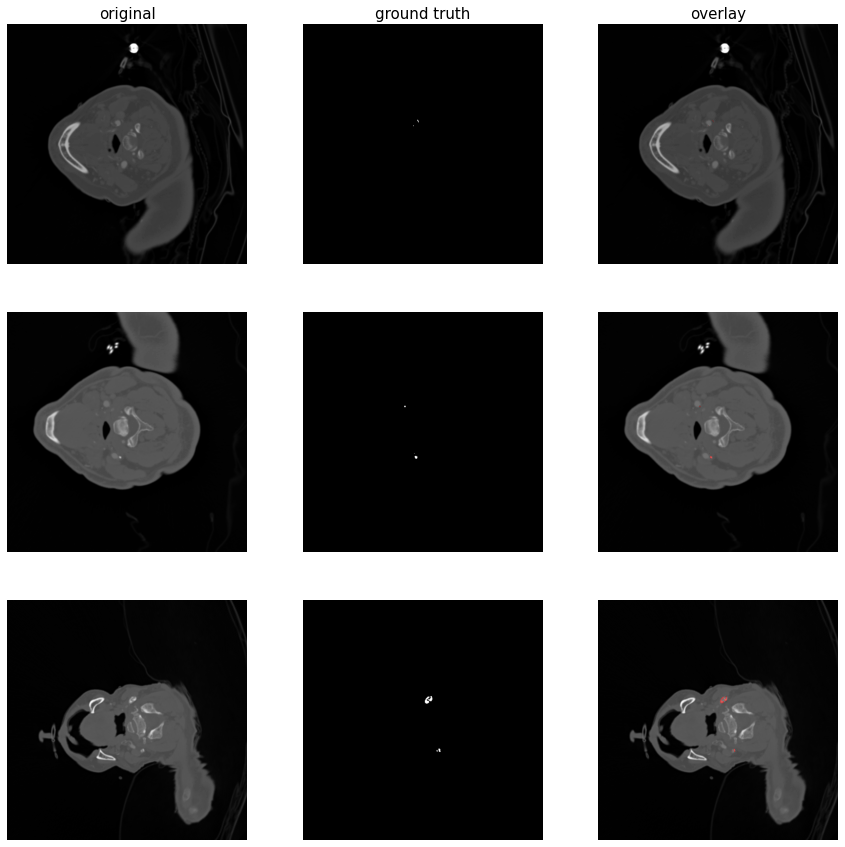

In [10]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=images, mask_imgs=labels, nm_img_to_plot=3, figsize=5)

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
X_train, X_val, y_train, y_val = C.Util.split_1(images, labels, val_size=0.2)

In [13]:
from keras_unet_collection import models, losses
import torch

model = models.swin_unet_2d((512, 512, 1), filter_num_begin=64,
                               n_labels=1, depth=4, stack_num_down=4, stack_num_up=4,
                               patch_size=(4, 4), num_heads=[4, 8, 16, 16],
                               window_size=[4, 2, 2, 2], num_mlp=512, 
                               output_activation='Sigmoid', shift_window=True, name='swin_unet')

#Softmax

2023-04-25 18:00:51.903172: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-04-25 18:00:52.135192: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:87:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-04-25 18:00:52.138030: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:90:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-04-25 18:00:52.138050: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-04-25 18:00:52.138086: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-04-25 

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


2023-04-25 18:00:52.194862: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-25 18:00:52.521202: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:87:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-04-25 18:00:52.530898: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:90:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-04-25 18:00:52.546203: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1871] Adding visible 

In [14]:
from tensorflow.keras import optimizers
from keras_unet.metrics import iou, iou_thresholded, dice_coef
from keras_unet_collection import losses

In [15]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(learning_rate = 0.001),
              metrics=[iou, iou_thresholded])

In [16]:
history = model.fit(X_train,
                    y_train,
                    batch_size=16,
                    epochs=100,
                    validation_data=(X_val, y_val))
                    #callbacks = [earlystopping])

2023-04-25 18:00:57.947839: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-04-25 18:00:57.969167: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2245645000 Hz


Epoch 1/100


2023-04-25 18:01:22.627739: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-04-25 18:01:23.816539: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2023-04-25 18:01:23.816889: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-04-25 18:01:23.950623: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2023-04-25 18:01:24.145659: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8500
2023-04-25 18:01:24.937497: W tensorflow/stream_executor/gpu/asm_compiler.cc:191] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.0
2023-04-25 18:01:24.937518: W tensorflow/stream_executor/gpu/asm_compiler.cc:194] Used ptxas at ptxas
2023-04-25 18:01:24.93788

39/39 [==============================] - 61s 870ms/step - loss: 0.0722 - iou: 9.8751e-04 - iou_thresholded: 0.0012 - val_loss: 0.0031 - val_iou: 0.0018 - val_iou_thresholded: 0.0019
Epoch 2/100
39/39 [==============================] - 29s 739ms/step - loss: 0.0027 - iou: 0.0013 - iou_thresholded: 0.0013 - val_loss: 0.0018 - val_iou: 0.0016 - val_iou_thresholded: 0.0019
Epoch 3/100
39/39 [==============================] - 29s 735ms/step - loss: 0.0034 - iou: 0.0013 - iou_thresholded: 0.0013 - val_loss: 0.0030 - val_iou: 0.0013 - val_iou_thresholded: 0.0019
Epoch 4/100
39/39 [==============================] - 29s 741ms/step - loss: 0.0020 - iou: 0.0012 - iou_thresholded: 0.0013 - val_loss: 0.0015 - val_iou: 0.0018 - val_iou_thresholded: 0.0019
Epoch 5/100
39/39 [==============================] - 29s 740ms/step - loss: 0.0015 - iou: 0.0023 - iou_thresholded: 0.0014 - val_loss: 0.0014 - val_iou: 0.0024 - val_iou_thresholded: 0.0019
Epoch 6/100
39/39 [==============================] - 29s 7

Epoch 43/100
39/39 [==============================] - 29s 740ms/step - loss: 1.9992e-04 - iou: 0.5003 - iou_thresholded: 0.6199 - val_loss: 3.7376e-04 - val_iou: 0.3959 - val_iou_thresholded: 0.4647
Epoch 44/100
39/39 [==============================] - 29s 738ms/step - loss: 1.8836e-04 - iou: 0.5201 - iou_thresholded: 0.6427 - val_loss: 3.9052e-04 - val_iou: 0.3935 - val_iou_thresholded: 0.4533
Epoch 45/100
39/39 [==============================] - 29s 744ms/step - loss: 1.7858e-04 - iou: 0.5359 - iou_thresholded: 0.6598 - val_loss: 3.5736e-04 - val_iou: 0.4069 - val_iou_thresholded: 0.4687
Epoch 46/100
39/39 [==============================] - 29s 740ms/step - loss: 1.7418e-04 - iou: 0.5471 - iou_thresholded: 0.6696 - val_loss: 3.7645e-04 - val_iou: 0.3958 - val_iou_thresholded: 0.4548
Epoch 47/100
39/39 [==============================] - 29s 736ms/step - loss: 1.6718e-04 - iou: 0.5591 - iou_thresholded: 0.6822 - val_loss: 3.7969e-04 - val_iou: 0.4074 - val_iou_thresholded: 0.4675
Epoch

39/39 [==============================] - 29s 736ms/step - loss: 7.7412e-05 - iou: 0.7679 - iou_thresholded: 0.8518 - val_loss: 4.6452e-04 - val_iou: 0.4772 - val_iou_thresholded: 0.4965
Epoch 85/100
39/39 [==============================] - 29s 738ms/step - loss: 6.4698e-05 - iou: 0.7921 - iou_thresholded: 0.8802 - val_loss: 4.4444e-04 - val_iou: 0.4969 - val_iou_thresholded: 0.5183
Epoch 86/100
39/39 [==============================] - 29s 739ms/step - loss: 5.4964e-05 - iou: 0.8138 - iou_thresholded: 0.9062 - val_loss: 4.5027e-04 - val_iou: 0.4975 - val_iou_thresholded: 0.5249
Epoch 87/100
39/39 [==============================] - 29s 738ms/step - loss: 5.0361e-05 - iou: 0.8237 - iou_thresholded: 0.9141 - val_loss: 4.3825e-04 - val_iou: 0.5091 - val_iou_thresholded: 0.5351
Epoch 88/100
39/39 [==============================] - 29s 742ms/step - loss: 4.3915e-05 - iou: 0.8396 - iou_thresholded: 0.9308 - val_loss: 4.5480e-04 - val_iou: 0.5122 - val_iou_thresholded: 0.5343
Epoch 89/100
39/39

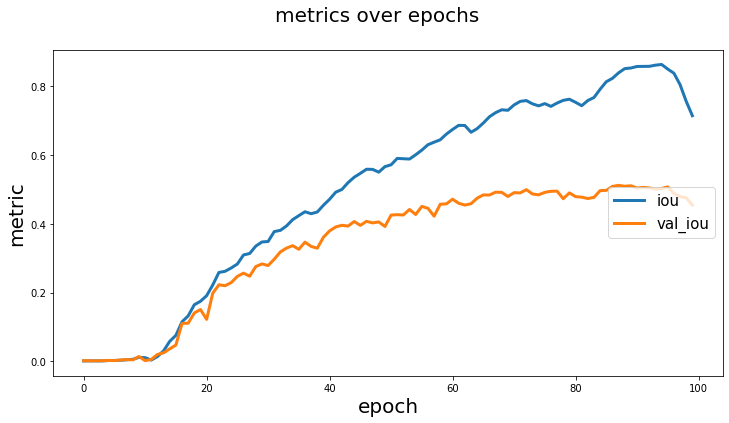

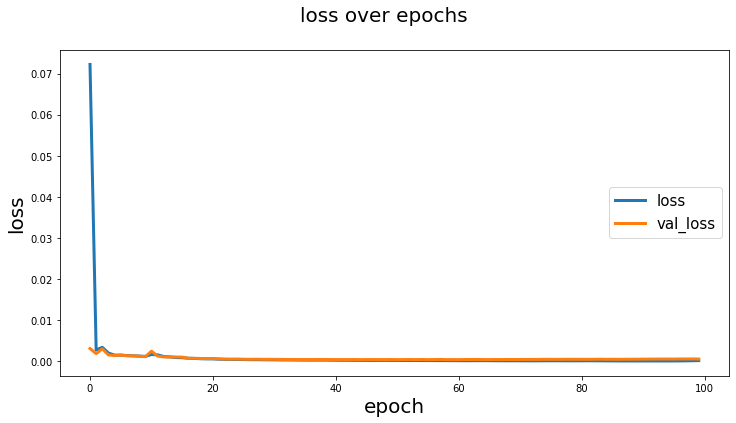

In [17]:
from keras_unet.utils import plot_segm_history

plot_segm_history(history)

In [18]:
y_pred = model.predict(X_val)

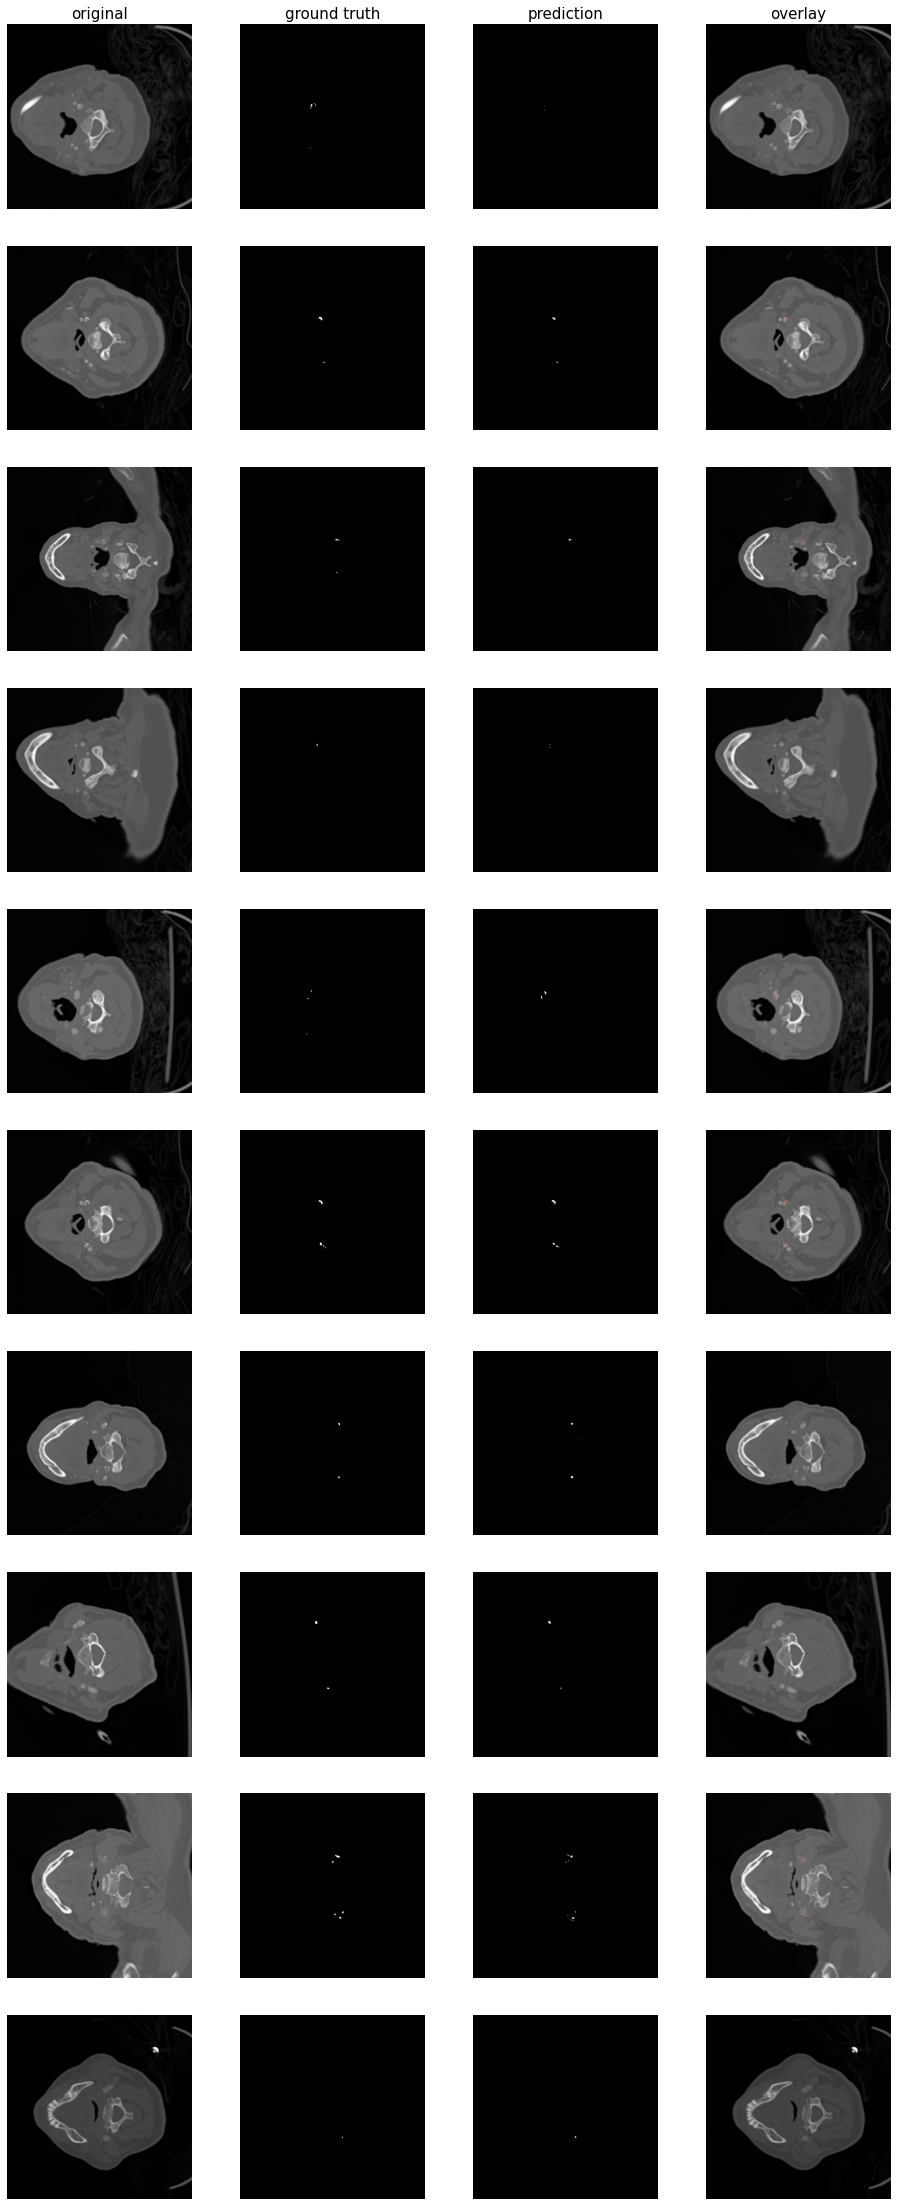

In [19]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=X_val, mask_imgs=y_val, pred_imgs=y_pred, nm_img_to_plot=10)

In [20]:
loss, iou, iou_thresholded = model.evaluate(X_val, y_val)

5/5 [==============================] - 2s 415ms/step - loss: 5.0660e-04 - iou: 0.4577 - iou_thresholded: 0.4860
